In [2]:
from data import AudioDataset
from model import CRNN
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, ConcatDataset
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


# create a new instance of the AudioDataset class for the test set
warblrb10k = AudioDataset(csv_file="../data/warblrb10k_public_metadata.csv", audio_dir="../data/warblrb10k_public/wav/")
ff1010 = AudioDataset(csv_file="../data/ff1010bird_metadata.csv", audio_dir="../data/ff1010bird/wav/")
birdvox = AudioDataset(csv_file="../data/BirdVoxDCASE20k_csvpublic.csv", audio_dir="../data/BirdVox-DCASE-20k/wav")

test_dataset = ConcatDataset([warblrb10k, ff1010, birdvox])

# create a DataLoader object to iterate over the test dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


FileNotFoundError: [Errno 2] No such file or directory: '../data/BirdVoxDCASE20k_csvpublic.csv'

In [ ]:
for data in [warblrb10k, ff1010, birdvox]:
    # Load the trained model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CRNN().to(device)
    model.load_state_dict(torch.load("../models/model_GRU_ATTENTION_2023-05-16_13-09-03.pt"))

    # Evaluate the model on the validation set
    model.eval()
    val_preds = []
    val_targets = []

    print("Evaluating...")
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.round()
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())
    print("Evaluating done!")

    print(f"AUC: {roc_auc_score(val_targets, val_preds):.4f}")
    print(f"Acc: {accuracy_score(val_targets, val_preds):.4f}")
    print(f"F1: {f1_score(val_targets, val_preds):.4f}")


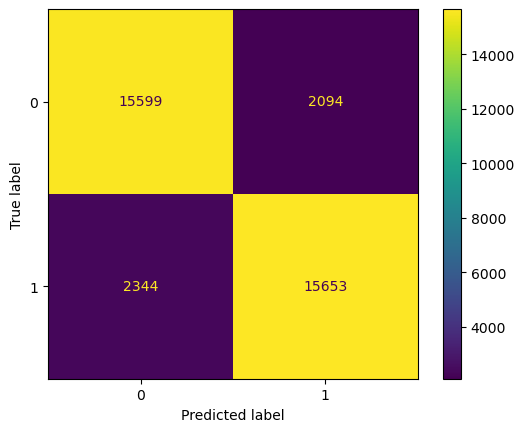

In [4]:
cm = confusion_matrix(val_targets, val_preds)

cm_display = ConfusionMatrixDisplay(cm).plot()

# plt.savefig("figures/cm_display.png", dpi=100, bbox_inches="tight")

## Résultats
### Nombre de features = 40

Entrainé sur 50% de la totalité des données avec un rapport train/test 60/40 (`n_mels` = 40). Evaluation sur la totalité :

|     | freefield     | warbrl | birdvox | ensemble |
|-----|:-------------:|:------:|:-------:|:--------:|
| AUC | **0.8274**    | 0.7827 | 0.8316  | 0.8372   |
| Acc | **0.8433**    | 0.8440 | 0.8315  | 0.8368   |
| F1  | **0.7187**    | 0.8974 | 0.8111  | 0.8302   |

Entrainé sur 100% de la totalité des données avec un rapport train/test 80/20 (`n_mels` = 40). Evaluation sur la totalité :

|     | freefield | warbrl     | birdvox | ensemble |
|-----|:---------:|:----------:|:-------:|:--------:|
| AUC | 0.8395    | 0.8177     | 0.8904  | 0.8757   |
| Acc | 0.8315    | **0.8816** | 0.8902  | 0.8757   |
| F1  | 0.7187    | **0.9233** | 0.8832  | 0.8758   |

### Nombre de features = 128

Entrainé sur 50% de la totalité des données avec un rapport train/test 60/40 (AUC: ~95% en train, 84.1642% en test), avec la totalité des features (`n_mels` = 128). Evaluation sur la totalité :

|     | freefield | warbrl     | birdvox     | ensemble     |
|-----|:---------:|:----------:|:-----------:|:------------:|
| AUC | 0.8058    | **0.7922** | **0.8693**  | **0.8469**   |
| Acc | 0.7713    | **0.8638** | **0.8691**  | **0.8468**   |
| F1  | 0.6582    | **0.9118** | **0.8562**  | **0.8469**   |

Entrainé sur 100% de la totalité des données avec un rapport train/test 80/20 (AUC : ~92% en train, ~87% en test), avec la totalité des features (`n_mels` = 128).
Evaluation sur la totalité :

|     | freefield     | warbrl     | birdvox     | ensemble     |
|-----|:-------------:|:----------:|:-----------:|:------------:|
| AUC | **0.8539**    | **0.8628** | **0.8962**  | **0.8875**   |
| Acc | **0.8735**    | 0.8781     | **0.8961**  | **0.8872**   |
| F1  | **0.7641**    | 0.9172     | **0.8881**  | **0.8832**   |

## Architecture


    Input : 40 x 500 (40 log mel-band energies over 500 frames)

Note : chaque couche convolutionnelle sont activées avec une fonction ReLU, sont batch normalized (BatchNorm) et un dropout est utilisé.

Couches convolutionnelles (au nombre de 4, 96 feature maps) : 

    Conv (5 x 5)      96 x 40 x 500
    MaxPool (5 x 1)   96 x 8 x 500

    Conv (5 x 5)      96 x 8 x 500
    MaxPool (2 x 1)   96 x 4 x 500

    Conv (5 x 5)      96 x 4 x 500
    MaxPool (2 x 1)   96 x 2 x 500

    Conv (5 x 5)      96 x 2 x 500
    MaxPool (2 x 1)   96 x 1 x 500

Couche récurrente :

    GRU               96 x 500

Max-pooling layer

    AdaptiveMaxPool1d 96 x 1

Feed-forward

    Linear            1
    Sigmoid           1


![reseau](figures/reseau.png)


    Input : 128 x 500 (128 log mel-band energies over 500 frames)

Couches convolutionnelles (au nombre de 4, 96 feature maps) (seules différences avec l'architecture précédente : la taille d'entrée et la taille des kernels des deux premières couches de pooling) : 

    Conv (5 x 5)      96 x 128 x 500
    MaxPool (8 x 1)   96 x 16 x 500

    Conv (5 x 5)      96 x 16 x 500
    MaxPool (4 x 1)   96 x 4 x 500

    Conv (5 x 5)      96 x 4 x 500
    MaxPool (2 x 1)   96 x 2 x 500

    Conv (5 x 5)      96 x 2 x 500
    MaxPool (2 x 1)   96 x 1 x 500


Le reste est identique.


### Notes

A **gated recurrent unit (GRU)** is a type of recurrent neural network (RNN) layer designed to address the vanishing gradient problem commonly faced in standard RNNs. The vanishing gradient problem arises when the gradients of the loss function with respect to the weights become very small during backpropagation, making it difficult for the network to learn long-term dependencies in the input data.

The GRU consists of two main gating mechanisms: the update gate and the reset gate. These gates help the network decide how much of the past information to keep and how much of the new information to consider when updating its hidden state. This allows the GRU to learn and retain long-term dependencies more effectively than standard RNNs.

When the authors mention "2 gated recurrent unit (GRU) layers with 96 hidden units," they are referring to a neural network architecture that has two sequential GRU layers, each containing 96 hidden units. This architecture allows the network to capture and model the temporal dependencies in the audio signals more effectively, which is crucial for tasks like bird audio detection.

**Batch normalization** is a technique used in training neural networks to standardize the inputs of each layer, i.e., to make sure that they have a mean output activation of zero and standard deviation of one. It is applied to the inputs of each layer before they are passed to the activation function.

Batch normalization helps in two ways:
- It reduces the problem known as "internal covariate shift," where the distributions of each layer's inputs change during training as the weights of the previous layers change. This can slow down training and make it harder for the network to converge.
- It allows each layer of the network to learn by itself a little more independently of other layers. It leads to faster training and reduces the sensitivity to initialization.

**Dropout** is a regularization technique used in training neural networks to prevent overfitting. During training, dropout involves randomly "dropping out," or deactivating, a number of outputs (neurons) in the layer during each training stage or iteration.

Dropout has the following benefits:
- It prevents complex co-adaptations on the training data by forcing the neurons to learn with a different "brain" configuration each time, which makes them more robust and less reliant on the presence of a few inputs.
- It effectively trains a large number of networks with different architectures in parallel, and the final prediction is an ensemble of these networks, which often leads to better generalization.

In convolutional layers, both batch normalization and dropout can help improve the robustness and generalization capability of the model. Batch normalization helps to standardize the layer inputs, making the training process more efficient, while dropout helps to make the model more robust and prevents overfitting by adding some form of noise or randomness to the layer outputs during training.

A **temporal max-pooling layer** is a type of pooling layer applied to time-based data. In the context of the paper, it is used to process the output from the gated recurrent unit (GRU) layers. The primary function of the temporal max-pooling layer is to reduce the temporal dimension of the input data while preserving its most important features. This is achieved by taking the maximum value from a certain number of consecutive time frames (determined by the pooling size) and outputting a single value. By reducing the temporal dimension, the max-pooling layer helps to reduce the computational complexity and the number of parameters in the network, thus improving efficiency and mitigating overfitting.

A **feedforward layer** is a basic component of an artificial neural network, consisting of multiple neurons (also called units or nodes) connected to the input data or the output of the previous layer. The primary function of a feedforward layer is to learn and apply a linear or non-linear transformation to the input data, helping to capture relationships or patterns within the data.

A single feedforward layer refers to a neural network layer with only one neuron (unit). In the context of the paper, this single feedforward layer takes the output from the temporal max-pooling layer and applies a linear or non-linear transformation with sigmoid activation. The output of this single neuron represents the probability of bird audio presence in the given audio file. Since the task at hand is binary classification (bird calls present or absent), a single neuron in the feedforward layer is sufficient to produce the desired output.

Bird sounds, or calls, typically occupy a specific, relatively narrow frequency range within the overall audio spectrum. In other words, bird calls are often characterized by certain frequency patterns that are distinguishable from other sounds.

From a theoretical standpoint, it makes sense to concentrate on extracting features from this particular frequency range when analyzing audio for bird sounds, as it would likely yield the most relevant and discriminative features for the task. By focusing on the specific frequency range where bird sounds are most prevalent, one can potentially improve the accuracy and efficiency of the bird audio detection system.

However, it is important to note that in the study, the authors found that using features from the entire frequency range provided better results than focusing only on the expected range for bird calls. This finding indicates that the complete frequency range still contains valuable information for the bird audio detection task.

Stucture of bird song has large diversity. Typical song may contain components which are pure sinusoidal, harmonic, nonharmonic, broadband and noisy in structure. Frequency range is relatively small, typically fundamental frequency lies between 3 and 5 kHz. [[1]](http://legacy.spa.aalto.fi/research/avesound/pubs/akusem04.pdf)